# ChatGPT o1 code 

In [1]:
import itertools
import random
random.seed(137) # random seed for reproduction

import numpy as np
import matplotlib.pyplot as plt

from functions import *

In [2]:
def calculate_gc_content(sequence):
    if type(sequence) == str:
        gc_count = sequence.count('G') + sequence.count('C')
        return (gc_count / len(sequence)) * 100  # GC percentage
    else:
        gc_content = []
        for seq in sequence:
            gc_content.append( (seq.count('G') + seq.count('C'))/len(seq) )
        return gc_content
        

def run_gpt_code(kmer, num_segments):
    # Step 1: Generate all possible 6-mer DNA sequences
    
    if type(kmer) == int:
        nucleotides = ['A', 'C', 'G', 'T']
        all_kmers = [''.join(p) for p in itertools.product(nucleotides, repeat=kmer)]
    elif type(kmer) == list:
        all_kmers = kmer
    else:
        assert False, "kmer must be either an int or a list"

    # Step 2: Calculate GC content for each 6-mer and bin them by GC count
    gc_bins = {i: [] for i in range(8)}  # GC content can range from 0 to 6
    for seq in all_kmers:
        gc_count = seq.count('G') + seq.count('C')
        gc_bins[gc_count].append(seq)

    # Shuffle sequences in each GC bin to randomize their order
    for gc_content in gc_bins:
        random.shuffle(gc_bins[gc_content])

    # Step 3: Initialize segment capacities
    total_sequences = len(all_kmers)
    #num_segments = 478  # 102 segments of size 40, 1 segment of size 16 (adjusted later)
    base_capacity = total_sequences // num_segments  # Base number of sequences per segment
    extra_sequences = total_sequences % num_segments  # Sequences remaining after base distribution

    segment_capacities = [base_capacity] * num_segments
    for i in range(extra_sequences):
        segment_capacities[i] += 1  # Distribute extra sequences among the first segments

    # Adjust last segment to reach 240nt by adding padding sequences if necessary
    max_segment_size = 40  # Maximum number of 6-mers per segment to reach 240nt
    for i in range(len(segment_capacities)):
        if segment_capacities[i] < max_segment_size:
            segment_capacities[i] = max_segment_size  # Pad with random sequences later

    # Step 4: Initialize segments
    segments = [{'sequences': [], 'current_size': 0, 'capacity': cap} for cap in segment_capacities]

    # Step 5: Distribute sequences from GC bins into segments
    segment_index = 0
    for gc_content in range(7):
        bin_sequences = gc_bins[gc_content]
        for seq in bin_sequences:
            # Find the next segment that has capacity
            while segments[segment_index % num_segments]['current_size'] >= segments[segment_index % num_segments]['capacity']:
                segment_index += 1
            # Assign sequence to the segment
            segment = segments[segment_index % num_segments]
            segment['sequences'].append(seq)
            segment['current_size'] += 1
            segment_index += 1

    # Step 6: Pad segments with fewer sequences to reach 240nt
    for segment in segments:
        while len(segment['sequences']) < max_segment_size:
            # Add random 6-mer to pad the segment
            random_seq = random.choice(all_kmers)
            segment['sequences'].append(random_seq)
            segment['current_size'] += 1

    # Step 7: Concatenate sequences in each segment and calculate GC content
        ### See the function above
    #def calculate_gc_content(sequence):
    #    gc_count = sequence.count('G') + sequence.count('C')
    #    return (gc_count / len(sequence)) * 100  # GC percentage

    segment_results = []
    for idx, segment in enumerate(segments):
        concatenated_seq = ''.join(segment['sequences'])
        gc_content = calculate_gc_content(concatenated_seq)
        segment_results.append({
            'segment_index': idx + 1,
            'sequence': concatenated_seq,
            'gc_content': gc_content
        })
           
    sequences = [item['sequence'] for item in segment_results]
    gc_content = [item['gc_content'] for item in segment_results]
            
    return sequences, gc_content

def plot_GC_content(gc_con, title=''):
    plt.plot(gc_con, 'o', c='b')
    plt.title(title, fontsize=12)
    plt.xlabel('read id', fontsize=9)
    plt.ylabel('GC content [%]', fontsize=9)
    plt.show()
    return None

# Heptamers in 500 segment

**Todo**:
- generate a 478 read long segment
- find the rare heptamers
- complete it to 500 reads: take care about GC-content
- check the frequency and GC-content
- save segments to `.fasta` and `.xlsx`


In [3]:
sequences, gc_content = run_gpt_code(7, 478)

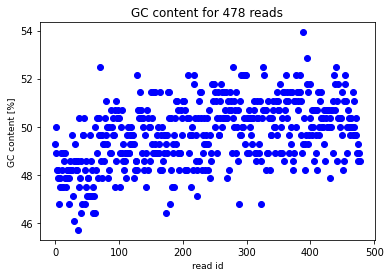

In [4]:
plot_GC_content(gc_content, 'GC content for 478 reads')

In [5]:
heptamers = generate_k_mer_list('ACTG', 7)
hexamers = generate_k_mer_list('ACTG', 6)

In [6]:
# In the empty reads how many hexamers can be paste?
# (number of reads left) * (lenght of a read) / (lenght of hexamer)
how_many_7mer_slots_left =  int((500-478) *240 / 7)
how_many_7mer_slots_left

754

In [7]:
# Get the firts `how_many_6mer_slots_left` rare hexamers.
kmer_counts = kmers_sorted_by_frequency(sequences, heptamers)
rare_7mers = kmer_counts[:how_many_7mer_slots_left, 0]

In [8]:
rare_7mer_sequence, rare_7mer_gc_content =  run_gpt_code(list(rare_7mers), 500-478)

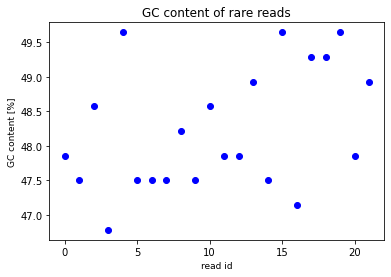

In [9]:
plot_GC_content(rare_7mer_gc_content, 'GC content of rare reads')

---

In [10]:
all500_sequences = sequences + rare_7mer_sequence
all500_gc_content = gc_content + rare_7mer_gc_content

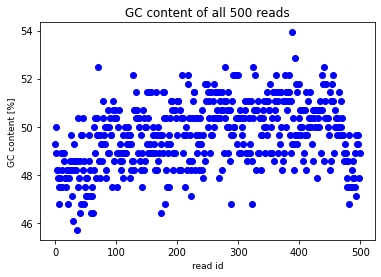

In [11]:
plot_GC_content(all500_gc_content, 'GC content of all 500 reads')

In [12]:
check_frequency(all500_sequences, heptamers)

\begin{run_chech()}
  frequency - the number of k-mers:
  2 - 13
  3 - 112
  4 - 914
  5 - 1555
  6 - 1972
  7 - 2216
  8 - 2358
  9 - 2095
  10 - 1689
  11 - 1260
  12 - 851
  13 - 581
  14 - 357
  15 - 202
  16 - 109
  17 - 50
  18 - 24
  19 - 19
  20 - 6
  21 - 1
\end{run_chech()}


In [13]:
check_frequency(all500_sequences, hexamers)

\begin{run_chech()}
  frequency - the number of k-mers:
  18 - 1
  20 - 5
  21 - 17
  22 - 25
  23 - 39
  24 - 79
  25 - 112
  26 - 144
  27 - 192
  28 - 189
  29 - 246
  30 - 275
  31 - 271
  32 - 301
  33 - 292
  34 - 272
  35 - 261
  36 - 226
  37 - 207
  38 - 175
  39 - 162
  40 - 125
  41 - 97
  42 - 76
  43 - 66
  44 - 62
  45 - 39
  46 - 37
  47 - 31
  48 - 26
  49 - 12
  50 - 8
  51 - 5
  52 - 10
  53 - 5
  54 - 4
  55 - 2
\end{run_chech()}


---
## Add the start and end basis to reads

In [14]:
promoter = "TCTTGTGGAAAGGACGAAACACCG"
terminator = "GTTTAAGAGCTATGCTGGAAACAG"

all500_sequences_with_limit_seq = []
for seq in all500_sequences:
    all500_sequences_with_limit_seq.append(promoter + seq + terminator)

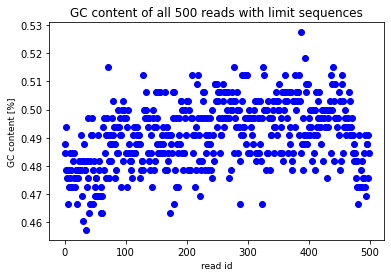

In [15]:
plot_GC_content(calculate_gc_content(all500_sequences_with_limit_seq), 'GC content of all 500 reads with limit sequences')


---
## Save data to `.fasta` and `.csv`/`.xlsx`

In [16]:
def save_to_fasta(sequences, file_name):
    with open(file_name, 'w') as fasta_file:
        for i, sequence in enumerate(sequences):
            fasta_file.write(f">sequence_{i + 1}\n")
            fasta_file.write(f"{sequence}\n")
    return None

save_to_fasta(all500_sequences_with_limit_seq, 'data/sequences.txt')
save_to_fasta(all500_sequences_with_limit_seq, 'data/sequences.fasta')

In [17]:
def save_to_excel(sequences, file_name):
    import pandas as pd
    seq_ids = [f"sequence_{i + 1}" for i in range(len(sequences))]
    df = pd.DataFrame({'Sequence ID': seq_ids, 'Sequence': sequences})
    df.to_excel(file_name, index=False)
    return None
    
save_to_excel(all500_sequences_with_limit_seq, 'data/sequences.xlsx')
